# Part One: SGD for Rank-1 Matrix Completion

Goal here is to compute SGD for matrix completion:
$$x_{t+1} = x_t - 2 \alpha (e_i^T x x^T e_j - e_i^T A e_j) (e_i e_j^T x + e_j e_i^T x).$$
First, we need to generate a matrix $A$ to try to recover at random.

In [1]:
using PyPlot;
using StatsBase;
using LinearAlgebra;
using Random

Random.seed!(8675309);

In [2]:
n = 100;
xopt = randn(n);
A = xopt * xopt';

In [3]:
# randomly sample the entries of A
K = 10000;
all_entries = [(i, j, A[i,j]) for i = 1:n for j = 1:n];
samples = sample(all_entries, K);

In [4]:
# define SGD for matrix completion
function sgd_matrixcompletion(samples, x0, alpha, niters, xopt)
    dists_to_optimum = zeros(niters);
    x = copy(x0);
    for k = 1:niters
        (i, j, Aij) = rand(samples); # randomly choose a sample
        xi = x[i];
        xj = x[j];
        x[i] -= 2 * alpha * (xi * xj - Aij) * xj;
        x[j] -= 2 * alpha * (xi * xj - Aij) * xi;
        dists_to_optimum[k] = min(norm(x - xopt), norm(x + xopt))
    end
    return (x, dists_to_optimum);
end

sgd_matrixcompletion (generic function with 1 method)

In [5]:
x0 = randn(n) / 5;
(xsoln1, dto1) = sgd_matrixcompletion(samples, x0, 0.1, 3*K, xopt);
(xsoln2, dto2) = sgd_matrixcompletion(samples, x0, 0.05, 3*K, xopt);

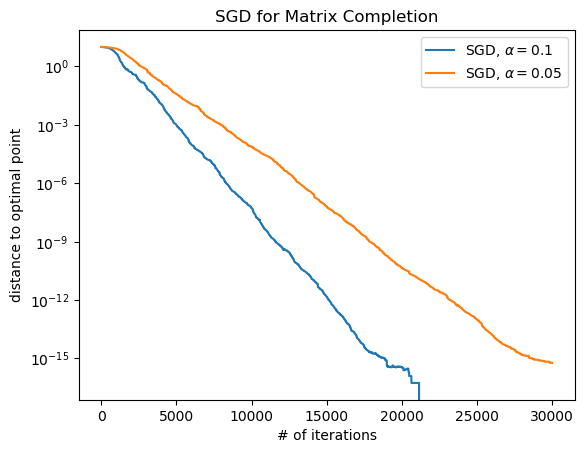

In [6]:
semilogy(dto1; label="SGD, \$\\alpha=0.1\$");
semilogy(dto2; label="SGD, \$\\alpha=0.05\$");
xlabel("# of iterations")
ylabel("distance to optimal point")
title("SGD for Matrix Completion")
legend();

We actually are converging down to the point where numerical precision is having an affect on our algorithm!

This is puzzing. **Why did we not converge to a noise ball?**

## Hypotheses?



Was it the specific way we did the sampling that caused this effect?

What if we sampled in a different way, where the samples are still unbiased in expectation, but have a little extra variance?  For example:

$$x_{t+1} = x_t - 2 \alpha (e_i^T x x^T e_j - e_i^T A e_j + \tilde z_t) (e_i e_j^T x + e_j e_i^T x).$$

where $\tilde z_t ~ N(0, \sigma^2)$ is a normally distributed random variable.

In [7]:
sigma = 0.001;

In [8]:
# define SGD for this new noisy matrix completion
function sgd_noisy_matrixcompletion(samples, x0, alpha, niters, xopt, sigma)
    dists_to_optimum = zeros(niters);
    x = copy(x0);
    for k = 1:niters
        (i, j, Aij) = rand(samples); # randomly choose a sample
        xi = x[i];
        xj = x[j];
        z = sigma * randn();
        x[i] -= 2 * alpha * (xi * xj - Aij + z) * xj;
        x[j] -= 2 * alpha * (xi * xj - Aij + z) * xi;
        dists_to_optimum[k] = min(norm(x - xopt), norm(x + xopt))
    end
    return (x, dists_to_optimum);
end

sgd_noisy_matrixcompletion (generic function with 1 method)

In [9]:
x0 = randn(n) / 5;
(xsoln, dto) = sgd_matrixcompletion(samples, x0, 0.1, 3*K, xopt);
(xsoln_noisy, dto_noisy) = sgd_noisy_matrixcompletion(samples, x0, 0.1, 3*K, xopt, sigma);

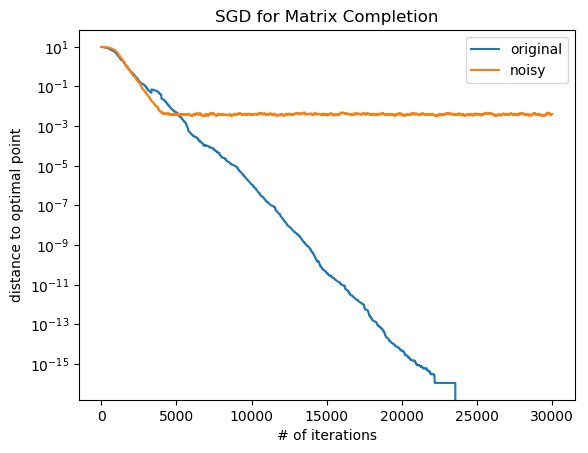

In [10]:
semilogy(dto; label = "original");
semilogy(dto_noisy; label = "noisy");
xlabel("# of iterations");
ylabel("distance to optimal point");
title("SGD for Matrix Completion");
legend();

When we add even a small amount of noise, now it converges to a noise ball again.

So it **is** something about the way we sampled that caused this effect!

Does it have something to do with the variance of the gradient estimator?

In [11]:
# define versions of the functions that estimate the variance by reporting the second moment of the gradient

function sgd_matrixcompletion_ve(samples, x0, alpha, niters, xopt, gssize)
    dists_to_optimum = zeros(niters);
    gradient_magnitude = zeros(niters);
    x = copy(x0);
    for k = 1:niters
        (i, j, Aij) = rand(samples); # randomly choose a sample
        xi = x[i];
        xj = x[j];
        x[i] -= 2 * alpha * (xi * xj - Aij) * xj;
        x[j] -= 2 * alpha * (xi * xj - Aij) * xi;
        dists_to_optimum[k] = min(norm(x - xopt), norm(x + xopt));
        gm = 0.0;
        for gi = 1:gssize
            (i, j, Aij) = rand(samples); # randomly choose a sample
            xi = x[i];
            xj = x[j];
            gm += (2 * alpha * (xi * xj - Aij))^2 * (xi^2 + xj ^2);
        end
        gradient_magnitude[k] = gm / gssize;
    end
    return (x, dists_to_optimum, gradient_magnitude);
end

function sgd_noisy_matrixcompletion_ve(samples, x0, alpha, niters, xopt, sigma, gssize)
    dists_to_optimum = zeros(niters);
    gradient_magnitude = zeros(niters);
    x = copy(x0);
    for k = 1:niters
        (i, j, Aij) = rand(samples); # randomly choose a sample
        xi = x[i];
        xj = x[j];
        z = sigma * randn();
        x[i] -= 2 * alpha * (xi * xj - Aij + z) * xj;
        x[j] -= 2 * alpha * (xi * xj - Aij + z) * xi;
        dists_to_optimum[k] = min(norm(x - xopt), norm(x + xopt));
        gm = 0.0;
        for gi = 1:gssize
            (i, j, Aij) = rand(samples); # randomly choose a sample
            xi = x[i];
            xj = x[j];
            z = sigma * randn();
            gm += (2 * alpha * (xi * xj - Aij + z))^2 * (xi^2 + xj ^2);
        end
        gradient_magnitude[k] = gm / gssize;
    end
    return (x, dists_to_optimum, gradient_magnitude);
end

sgd_noisy_matrixcompletion_ve (generic function with 1 method)

In [12]:
x0 = randn(n) / 5;
(xsoln, dto, gm) = sgd_matrixcompletion_ve(samples, x0, 0.1, 3*K, xopt, 10);
(xsoln_noisy, dto_noisy, gm_noisy) = sgd_noisy_matrixcompletion_ve(samples, x0, 0.1, 3*K, xopt, sigma, 10);

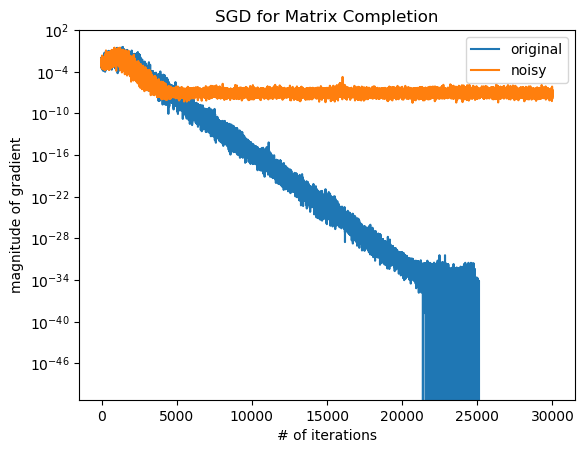

In [13]:
semilogy(gm; label = "original");
semilogy(gm_noisy; label = "noisy");
xlabel("# of iterations");
ylabel("magnitude of gradient");
title("SGD for Matrix Completion");
legend();

So what's actually happening here?

**The variance of the estimator is going to zero as the algorithm converges!**

This is different from how it works for SGD for most problems, where the variance is nonzero even at the optimal point.

# Part Two: Stochastic Variance-Reduced Gradient (SVRG)

In [14]:
Random.seed!(8675309);

In [15]:
# generate a naive bayes model
d = 10;
N = 10000;
wtrue = randn(d);
X = randn(N, d);
y = (1 ./ (1 .+ exp.(-X * wtrue)) .>= rand(N)) * 2 .- 1;

In [16]:
function sgd(w0, alpha, X, y, niters, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        i = rand(1:N)
        xi = X[i,:];
        yi = y[i];
        w = w + alpha * xi * yi ./ (1 .+ exp.(yi * dot(xi, w)));
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

function svrg(w0, alpha, X, y, niters, nepochs, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters * nepochs)
    for epi = 1:nepochs
        wtilde = w;
        gtilde = zeros(d);
        for i = 1:N
            xi = X[i,:];
            yi = y[i];
            gtilde += xi * yi ./ (1 .+ exp.(yi * dot(xi, wtilde)));
        end
        gtilde /= N;
        for k = 1:niters
            i = rand(1:N)
            xi = X[i,:];
            yi = y[i];
            w = w + alpha * (xi * yi ./ (1 .+ exp.(yi * dot(xi, w))) - xi * yi ./ (1 .+ exp.(yi * dot(xi, wtilde))) + gtilde);
            dist_to_optimum[k + (epi-1)*niters] = norm(w - wopt);
        end
    end
    return (w, dist_to_optimum);
end

svrg (generic function with 1 method)

In [17]:
# initial random weights
w0 = randn(d);

In [18]:
# solve the problem using SVRG to get the optimum, which we'll use later.
(wopt, dto_opt) = svrg(w0, 0.02, X, y, 10000, 100, wtrue);

In [21]:
@time (w, dto) = svrg(w0, 0.02, X, y, 5000, 20, wopt);
@time (w, dto2) = sgd(w0, 0.02, X, y, 5000 * 20, wopt);
@time (w, dto3) = sgd(w0, 0.002, X, y, 5000 * 20, wopt);

  0.134337 seconds (1.80 M allocations: 275.428 MiB, 6.84% gc time)
  0.049014 seconds (600.01 k allocations: 92.316 MiB, 11.97% gc time)
  0.041280 seconds (600.01 k allocations: 92.316 MiB, 5.05% gc time)


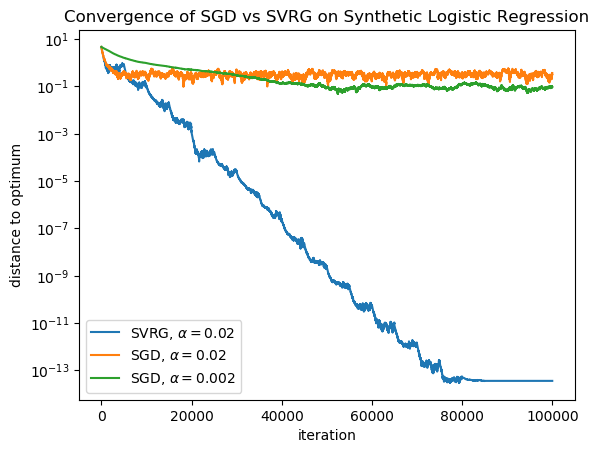

In [20]:
semilogy(dto; label="SVRG, \$\\alpha=0.02\$");
semilogy(dto2; label="SGD, \$\\alpha=0.02\$");
semilogy(dto3; label="SGD, \$\\alpha=0.002\$");

title("Convergence of SGD vs SVRG on Synthetic Logistic Regression");
ylabel("distance to optimum");
xlabel("iteration");
legend();